In [2]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
#import the data
df = pd.read_csv('RecGym.csv')

In [4]:
# for balancing sessions
def balance_sessions(df, label_col='Workout', subj_col='Subject', sess_col='Session',
                    n_subjects=None, n_sessions=None, random_state=42):
    """
    Balance at the SESSION level (before windowing).
    Returns a dataframe of balanced sessions that can be used to filter the original data.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe with raw time-series data
    label_col : str
        Column name for workout labels
    subj_col : str
        Column name for subject IDs
    sess_col : str
        Column name for session IDs
    n_subjects : int, optional
        Number of subjects to select per workout. If None, uses minimum across workouts
    n_sessions : int, optional
        Number of sessions to select per subject. If None, uses minimum across subjects
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    DataFrame with columns [Workout, Subject, Session] containing balanced sessions
    """
    rng = np.random.RandomState(random_state)
    
    # Get unique sessions
    sessions_df = df[[label_col, subj_col, sess_col]].drop_duplicates()
    
    # Compute defaults if not provided
    if n_subjects is None:
        n_subjects = sessions_df.groupby(label_col)[subj_col].nunique().min()
    if n_sessions is None:
        n_sessions = sessions_df.groupby([label_col, subj_col])[sess_col].nunique().min()
    
    print(f"Balancing to: {n_subjects} subjects per workout, {n_sessions} sessions per subject")
    
    balanced_sessions = []
    
    # Iterate through each workout
    for workout, g_workout in sessions_df.groupby(label_col):
        # Randomly select subjects
        subjects = g_workout[subj_col].unique()
        chosen_subjects = rng.choice(subjects, size=n_subjects, replace=False)
        
        for subj in chosen_subjects:
            g_subj = g_workout[g_workout[subj_col] == subj]
            sessions = g_subj[sess_col].unique()
            chosen_sessions = rng.choice(sessions, size=n_sessions, replace=False)
            
            # Add these sessions
            mask = (sessions_df[label_col] == workout) & \
                   (sessions_df[subj_col] == subj) & \
                   (sessions_df[sess_col].isin(chosen_sessions))
            balanced_sessions.append(sessions_df[mask])
    
    balanced_sessions_df = pd.concat(balanced_sessions).reset_index(drop=True)
    
    # Print summary
    print(f"\nBalanced sessions summary:")
    print(f"Total sessions: {len(balanced_sessions_df)}")
    print(f"Sessions per workout: {balanced_sessions_df.groupby(label_col).size().unique()}")
    
    return balanced_sessions_df

In [5]:
def create_raw_windows(df, window_size=100, step_size=50):
    """
    Create raw time-series windows without aggregation.
    
    Returns:
    - X: array of shape (n_windows, window_size, n_channels)
    - y: array of workout labels
    - metadata: dataframe with Subject, Session info for each window
    """
    windows = []
    labels = []
    metadata = []
    
    # Sensor columns (channels)
    sensor_cols = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1']
    
    for (workout, subject, session), group in df.groupby(['Workout', 'Subject', 'Session']):
        # Sort by position if available, otherwise assume data is ordered
        if 'Position' in group.columns:
            group = group.sort_values('Position')
        
        # Extract sensor data
        sensor_data = group[sensor_cols].values
        
        # Create sliding windows
        for start_idx in range(0, len(sensor_data) - window_size + 1, step_size):
            window = sensor_data[start_idx:start_idx + window_size]
            
            windows.append(window)
            labels.append(workout)
            metadata.append({
                'Subject': subject,
                'Session': session,
                'Workout': workout,
                'Window_idx': start_idx // step_size
            })
    
    X = np.array(windows)  # Shape: (n_windows, window_size, n_channels)
    y = np.array(labels)
    metadata_df = pd.DataFrame(metadata)
    
    return X, y, metadata_df

# Example usage
print("Creating raw windows...")
X_raw, y_raw, metadata = create_raw_windows(df, window_size=100, step_size=50)

print(f"X_raw shape: {X_raw.shape}")  # Should be (n_windows, 100, 7)
print(f"  - Number of windows: {X_raw.shape[0]}")
print(f"  - Window size (timesteps): {X_raw.shape[1]}")
print(f"  - Number of channels (sensors): {X_raw.shape[2]}")
print(f"y_raw shape: {y_raw.shape}")

Creating raw windows...
X_raw shape: (93176, 100, 7)
  - Number of windows: 93176
  - Window size (timesteps): 100
  - Number of channels (sensors): 7
y_raw shape: (93176,)


In [6]:
# ============================================
# CORRECT APPROACH: SPLIT BY SUBJECT
# ============================================

def balance_and_split_by_subject(df, label_col='Workout', subj_col='Subject', 
                                 sess_col='Session', random_state=42):
    """
    Balance and split ensuring NO subject appears in multiple splits.
    This is the correct way to prevent data leakage.
    """
    rng = np.random.RandomState(random_state)
    
    # Get all unique subjects in the dataset
    all_subjects = df[subj_col].unique()
    print(f"Total unique subjects: {len(all_subjects)}")
    
    # Split subjects into train/cv/test (60/20/20)
    n_subjects = len(all_subjects)
    rng.shuffle(all_subjects)
    
    n_train = int(0.6 * n_subjects)
    n_cv = int(0.2 * n_subjects)
    
    train_subjects = all_subjects[:n_train]
    cv_subjects = all_subjects[n_train:n_train + n_cv]
    test_subjects = all_subjects[n_train + n_cv:]
    
    print(f"Train subjects: {len(train_subjects)}")
    print(f"CV subjects: {len(cv_subjects)}")
    print(f"Test subjects: {len(test_subjects)}")
    
    # Create session lists for each split
    train_sessions = df[df[subj_col].isin(train_subjects)][[label_col, subj_col, sess_col]].drop_duplicates()
    cv_sessions = df[df[subj_col].isin(cv_subjects)][[label_col, subj_col, sess_col]].drop_duplicates()
    test_sessions = df[df[subj_col].isin(test_subjects)][[label_col, subj_col, sess_col]].drop_duplicates()
    
    print(f"\nTrain sessions: {len(train_sessions)}")
    print(f"CV sessions: {len(cv_sessions)}")
    print(f"Test sessions: {len(test_sessions)}")
    
    # Check workout distribution
    print("\nWorkout distribution:")
    print("Train:")
    print(train_sessions[label_col].value_counts().sort_index())
    print("\nCV:")
    print(cv_sessions[label_col].value_counts().sort_index())
    print("\nTest:")
    print(test_sessions[label_col].value_counts().sort_index())
    
    return train_sessions, cv_sessions, test_sessions, train_subjects, cv_subjects, test_subjects


# ============================================
# COMPLETE PIPELINE WITH SUBJECT-LEVEL SPLIT
# ============================================

print("="*60)
print("STEP 1: BALANCE SESSIONS")
print("="*60)

balanced_sessions = balance_sessions(
    df, 
    label_col='Workout', 
    subj_col='Subject', 
    sess_col='Session'
)

# Filter to balanced sessions
df_balanced = df.merge(balanced_sessions, on=['Workout', 'Subject', 'Session'], how='inner')

print(f"\nBalanced data: {len(df_balanced)} rows")

print("\n" + "="*60)
print("STEP 2: SPLIT BY SUBJECT (NO LEAKAGE)")
print("="*60)

train_sessions, cv_sessions, test_sessions, train_subj, cv_subj, test_subj = \
    balance_and_split_by_subject(df_balanced, label_col='Workout', 
                                 subj_col='Subject', sess_col='Session')

# Add split labels
train_sessions['split'] = 'train'
cv_sessions['split'] = 'cv'
test_sessions['split'] = 'test'

all_splits = pd.concat([train_sessions, cv_sessions, test_sessions])

# Merge with balanced data
df_with_splits = df_balanced.merge(all_splits, on=['Workout', 'Subject', 'Session'], how='inner')

print("\n" + "="*60)
print("STEP 3: CREATE RAW WINDOWS")
print("="*60)

# Separate by split
df_train = df_with_splits[df_with_splits['split'] == 'train'].drop(columns=['split'])
df_cv = df_with_splits[df_with_splits['split'] == 'cv'].drop(columns=['split'])
df_test = df_with_splits[df_with_splits['split'] == 'test'].drop(columns=['split'])

print("Creating raw windows for each split...")
X_train_raw, y_train, metadata_train = create_raw_windows(df_train, window_size=100, step_size=50)
X_cv_raw, y_cv, metadata_cv = create_raw_windows(df_cv, window_size=100, step_size=50)
X_test_raw, y_test, metadata_test = create_raw_windows(df_test, window_size=100, step_size=50)

print(f"\nX_train_raw: {X_train_raw.shape}")
print(f"X_cv_raw: {X_cv_raw.shape}")
print(f"X_test_raw: {X_test_raw.shape}")

print("\n" + "="*60)
print("STEP 4: VERIFY NO DATA LEAKAGE")
print("="*60)

# Check at SUBJECT level (most important)
train_subjects_set = set(metadata_train['Subject'].unique())
cv_subjects_set = set(metadata_cv['Subject'].unique())
test_subjects_set = set(metadata_test['Subject'].unique())

subject_overlap_train_cv = train_subjects_set & cv_subjects_set
subject_overlap_train_test = train_subjects_set & test_subjects_set
subject_overlap_cv_test = cv_subjects_set & test_subjects_set

print("SUBJECT-level overlap check:")
print(f"Train-CV overlap: {len(subject_overlap_train_cv)} (should be 0)")
print(f"Train-Test overlap: {len(subject_overlap_train_test)} (should be 0)")
print(f"CV-Test overlap: {len(subject_overlap_cv_test)} (should be 0)")

if len(subject_overlap_train_cv) == 0 and len(subject_overlap_train_test) == 0 and len(subject_overlap_cv_test) == 0:
    print("✓✓✓ NO SUBJECT OVERLAP - No data leakage!")
else:
    print("⚠️ WARNING: Subjects appear in multiple splits!")
    if subject_overlap_train_cv:
        print(f"  Train-CV overlap subjects: {subject_overlap_train_cv}")
    if subject_overlap_train_test:
        print(f"  Train-Test overlap subjects: {subject_overlap_train_test}")

# Also check at session level
train_sessions_set = set(zip(metadata_train['Subject'], metadata_train['Session']))
cv_sessions_set = set(zip(metadata_cv['Subject'], metadata_cv['Session']))
test_sessions_set = set(zip(metadata_test['Subject'], metadata_test['Session']))

session_overlap_train_cv = train_sessions_set & cv_sessions_set
session_overlap_train_test = train_sessions_set & test_sessions_set
session_overlap_cv_test = cv_sessions_set & test_sessions_set

print("\nSESSION-level overlap check:")
print(f"Train-CV overlap: {len(session_overlap_train_cv)} (should be 0)")
print(f"Train-Test overlap: {len(session_overlap_train_test)} (should be 0)")
print(f"CV-Test overlap: {len(session_overlap_cv_test)} (should be 0)")

if len(session_overlap_train_cv) == 0 and len(session_overlap_train_test) == 0 and len(session_overlap_cv_test) == 0:
    print("✓✓✓ NO SESSION OVERLAP - Confirmed no data leakage!")
else:
    print("⚠️ WARNING: Sessions appear in multiple splits!")

print("\n" + "="*60)
print("STEP 5: NORMALIZE DATA")
print("="*60)

# Reshape for scaling
n_train_samples, n_timesteps, n_channels = X_train_raw.shape
X_train_reshaped = X_train_raw.reshape(-1, n_channels)

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled_flat.reshape(n_train_samples, n_timesteps, n_channels)

# Transform CV and test
X_cv_scaled = scaler.transform(X_cv_raw.reshape(-1, n_channels)).reshape(X_cv_raw.shape)
X_test_scaled = scaler.transform(X_test_raw.reshape(-1, n_channels)).reshape(X_test_raw.shape)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_cv_scaled: {X_cv_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

print("\n" + "="*60)
print("STEP 6: ENCODE LABELS")
print("="*60)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_cv_encoded = le.transform(y_cv)
y_test_encoded = le.transform(y_test)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

print("\n" + "="*60)
print("FINAL DATA SUMMARY")
print("="*60)
print(f"Training windows: {X_train_scaled.shape[0]}")
print(f"CV windows: {X_cv_scaled.shape[0]}")
print(f"Test windows: {X_test_scaled.shape[0]}")
print(f"Window size: {n_timesteps} timesteps")
print(f"Number of sensor channels: {n_channels}")
print(f"Number of workout classes: {num_classes}")

print("\nClass distribution:")
print("Train:", np.bincount(y_train_encoded))
print("CV:", np.bincount(y_cv_encoded))
print("Test:", np.bincount(y_test_encoded))


STEP 1: BALANCE SESSIONS
Balancing to: 10 subjects per workout, 4 sessions per subject

Balanced sessions summary:
Total sessions: 480
Sessions per workout: [40]

Balanced data: 3817146 rows

STEP 2: SPLIT BY SUBJECT (NO LEAKAGE)
Total unique subjects: 10
Train subjects: 6
CV subjects: 2
Test subjects: 2

Train sessions: 288
CV sessions: 96
Test sessions: 96

Workout distribution:
Train:
Workout
Adductor        24
ArmCurl         24
BenchPress      24
LegCurl         24
LegPress        24
Null            24
Riding          24
RopeSkipping    24
Running         24
Squat           24
StairClimber    24
Walking         24
Name: count, dtype: int64

CV:
Workout
Adductor        8
ArmCurl         8
BenchPress      8
LegCurl         8
LegPress        8
Null            8
Riding          8
RopeSkipping    8
Running         8
Squat           8
StairClimber    8
Walking         8
Name: count, dtype: int64

Test:
Workout
Adductor        8
ArmCurl         8
BenchPress      8
LegCurl         8
LegPr

In [7]:
#step 5 - building the CNN model

print("\nStep 5: Building 1D-CNN model...")

tf.random.set_seed(1234)

model_cnn = Sequential([
    # Input shape: (window_size, n_channels)
    tf.keras.Input(shape=(n_timesteps, n_channels)),
    
    # First Convolutional Block
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', name='conv1'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, name='pool1'),
    Dropout(0.2),
    
    # Second Convolutional Block
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name='conv2'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, name='pool2'),
    Dropout(0.3),
    
    # Third Convolutional Block
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same', name='conv3'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, name='pool3'),
    Dropout(0.3),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), name='dense1'),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense2'),
    Dropout(0.3),
    
    # Output Layer
    Dense(num_classes, activation='softmax', name='output')
], name='1D_CNN_Workout_Classifier')

model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Display architecture
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model_cnn.summary()


Step 5: Building 1D-CNN model...

MODEL ARCHITECTURE


Model: "1D_CNN_Workout_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 100, 64)        │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling1D)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 50, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling1D)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 25, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling1D)            │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 546,124 (2.08 MB)

 Trainable params: 545,228 (2.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
#step 6 - training the model

print("\n" + "="*60)
print("TRAINING 1D-CNN MODEL")
print("="*60)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train
history_cnn = model_cnn.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_cv_scaled, y_cv_encoded),
    epochs=100,
    batch_size=64,  # Smaller batch size for CNN
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\nTraining stopped at epoch {len(history_cnn.history['loss'])}")


TRAINING 1D-CNN MODEL
Epoch 1/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6377 - loss: 1.5694 - val_accuracy: 0.7306 - val_loss: 1.2101 - learning_rate: 0.0010
Epoch 2/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7576 - loss: 1.0210 - val_accuracy: 0.7626 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 3/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8046 - loss: 0.8274 - val_accuracy: 0.7940 - val_loss: 0.8269 - learning_rate: 0.0010
Epoch 4/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8330 - loss: 0.7143 - val_accuracy: 0.8122 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 5/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8467 - loss: 0.6542 - val_accuracy: 0.8320 - val_loss: 0.7271 - learning_rate: 0.0010
Epoch 6/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8604 - loss: 0.6068 - val_accuracy: 0.8325 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 7/100
721/721 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/st

In [9]:
# Evaluate
train_loss_cnn, train_acc_cnn = model_cnn.evaluate(X_train_scaled, y_train_encoded, verbose=0)
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(X_cv_scaled, y_cv_encoded, verbose=0)
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n" + "="*60)
print("1D-CNN MODEL RESULTS")
print("="*60)
print(f"Train - Loss: {train_loss_cnn:.3f}, Accuracy: {train_acc_cnn:.3f}")
print(f"Val   - Loss: {val_loss_cnn:.3f}, Accuracy: {val_acc_cnn:.3f}")
print(f"Test  - Loss: {test_loss_cnn:.3f}, Accuracy: {test_acc_cnn:.3f}")
print(f"Overfit gap: {(train_acc_cnn - test_acc_cnn)*100:.2f}%")


1D-CNN MODEL RESULTS
Train - Loss: 0.106, Accuracy: 0.971
Val   - Loss: 0.547, Accuracy: 0.881
Test  - Loss: 0.769, Accuracy: 0.860
Overfit gap: 11.06%


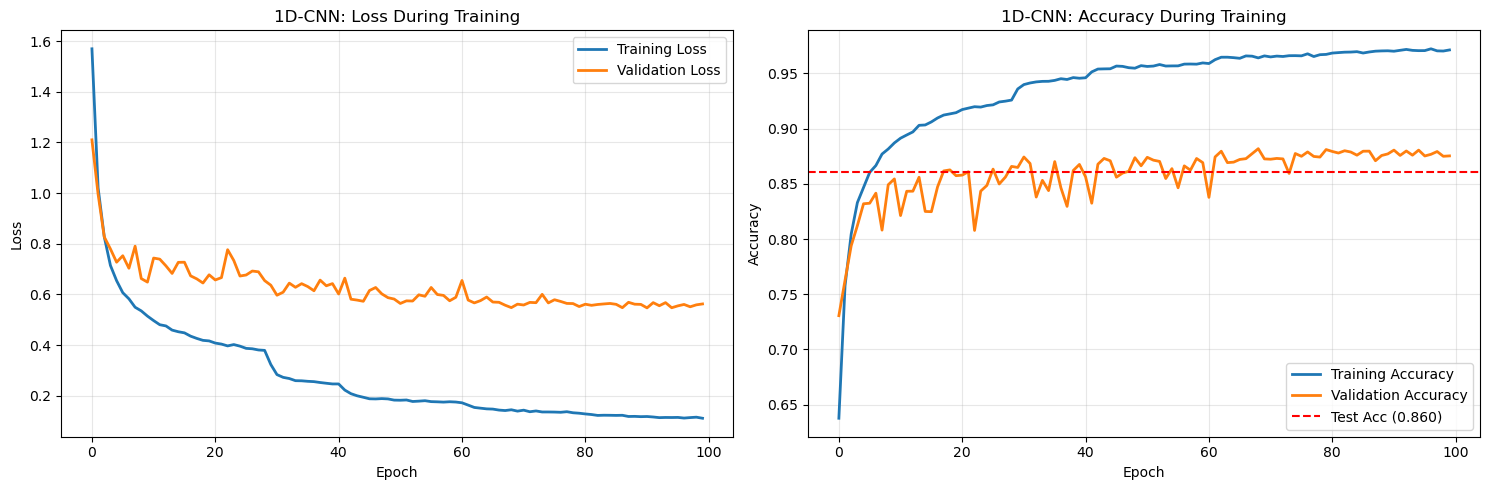

In [10]:
#visualizing the model

# Training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_cnn.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('1D-CNN: Loss During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_cnn.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.axhline(y=test_acc_cnn, color='red', linestyle='--', label=f'Test Acc ({test_acc_cnn:.3f})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('1D-CNN: Accuracy During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CONFUSION MATRIX FOR ORIGINAL 1D-CNN MODEL

Model Performance:
Train - Loss: 0.1061, Accuracy: 0.9709 (97.09%)
Val   - Loss: 0.5468, Accuracy: 0.8806 (88.06%)
Test  - Loss: 0.7694, Accuracy: 0.8603 (86.03%)
Overfit gap: 11.06%


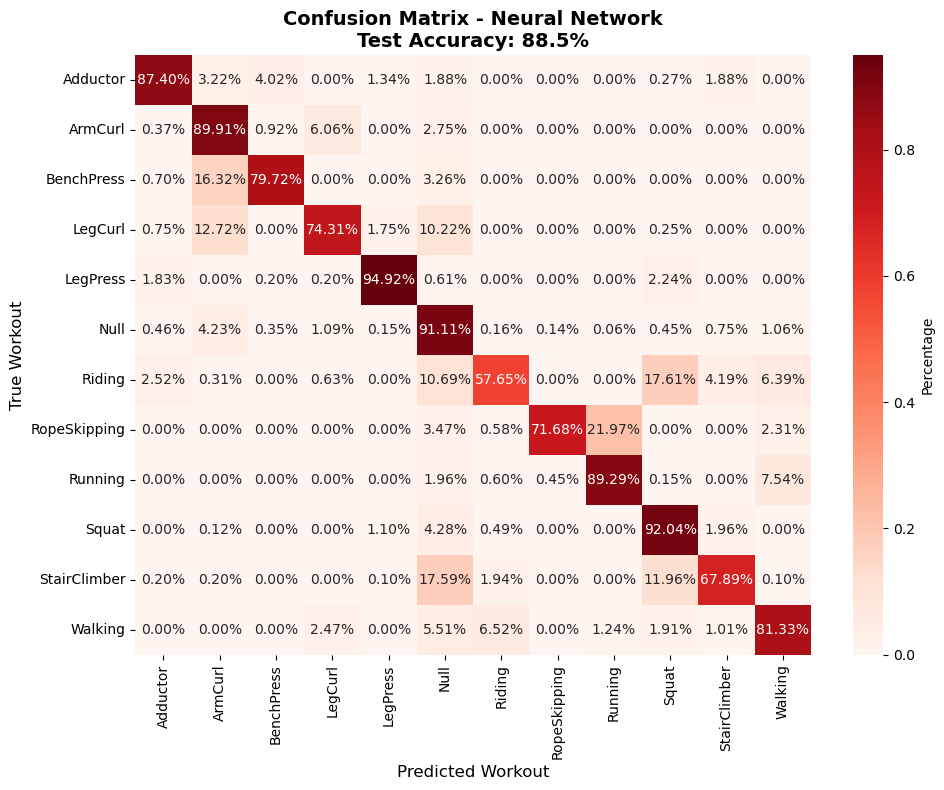


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Adductor      0.795     0.874     0.833       373
     ArmCurl      0.489     0.899     0.633       545
  BenchPress      0.868     0.797     0.831       429
     LegCurl      0.654     0.743     0.695       401
    LegPress      0.930     0.949     0.940       492
        Null      0.946     0.911     0.928      8827
      Riding      0.846     0.577     0.686       954
RopeSkipping      0.892     0.717     0.795       173
     Running      0.916     0.893     0.905       663
       Squat      0.679     0.920     0.781       817
StairClimber      0.828     0.679     0.746       978
     Walking      0.775     0.813     0.794       889

    accuracy                          0.860     15541
   macro avg      0.802     0.814     0.797     15541
weighted avg      0.877     0.860     0.863     15541


PER-CLASS ACCURACY (SORTED BY ACCURACY)
     Workout Accuracy %  Correct  Total  Errors
    LegPress

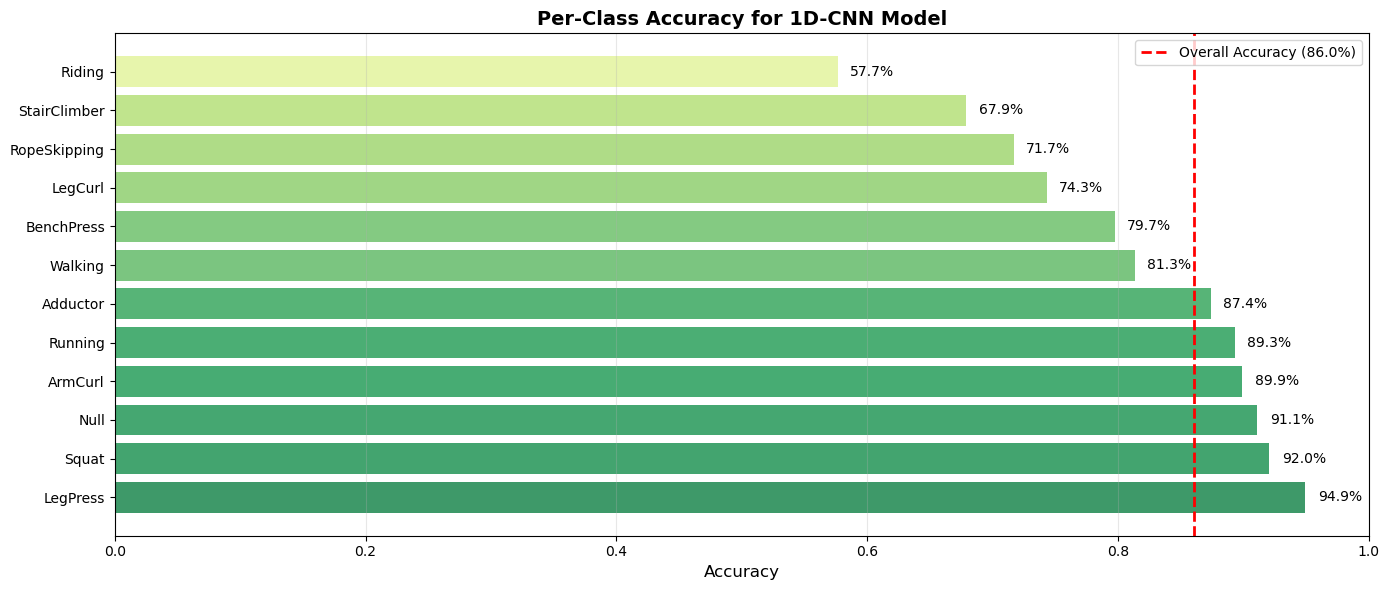

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*60)
print("CONFUSION MATRIX FOR ORIGINAL 1D-CNN MODEL")
print("="*60)

# Evaluate the model
train_loss_cnn, train_acc_cnn = model_cnn.evaluate(X_train_scaled, y_train_encoded, verbose=0)
val_loss_cnn, val_acc_cnn = model_cnn.evaluate(X_cv_scaled, y_cv_encoded, verbose=0)
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print(f"\nModel Performance:")
print(f"Train - Loss: {train_loss_cnn:.4f}, Accuracy: {train_acc_cnn:.4f} ({train_acc_cnn*100:.2f}%)")
print(f"Val   - Loss: {val_loss_cnn:.4f}, Accuracy: {val_acc_cnn:.4f} ({val_acc_cnn*100:.2f}%)")
print(f"Test  - Loss: {test_loss_cnn:.4f}, Accuracy: {test_acc_cnn:.4f} ({test_acc_cnn*100:.2f}%)")
print(f"Overfit gap: {(train_acc_cnn - test_acc_cnn)*100:.2f}%")

# Get predictions
test_pred_probs = model_cnn.predict(X_test_scaled, verbose=0)
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, test_pred_classes)

plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Confusion Matrix - Neural Network\nTest Accuracy: 88.5%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Workout', fontsize=12)
plt.xlabel('Predicted Workout', fontsize=12)
plt.tight_layout()
plt.show()

"""
# for plotting in both ways

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'}, linewidths=0.5, annot_kws={"fontsize": 10})
ax1.set_title(f'1D-CNN Model - Confusion Matrix (Counts)\nTest Accuracy: {test_acc_cnn:.1%}', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('True Workout', fontsize=13)
ax1.set_xlabel('Predicted Workout', fontsize=13)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=11)

# Plot 2: Normalized by true class (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds', ax=ax2,
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage'}, linewidths=0.5, 
            vmin=0, vmax=1, annot_kws={"fontsize": 10})
ax2.set_title(f'1D-CNN Model - Confusion Matrix (Normalized)\nTest Accuracy: {test_acc_cnn:.1%}', 
              fontsize=16, fontweight='bold')
ax2.set_ylabel('True Workout', fontsize=13)
ax2.set_xlabel('Predicted Workout', fontsize=13)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=11)

plt.tight_layout()
plt.show()

"""

# Print detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test_encoded, test_pred_classes, 
                          target_names=le.classes_, digits=3))

# Per-class accuracy analysis
print("\n" + "="*70)
print("PER-CLASS ACCURACY (SORTED BY ACCURACY)")
print("="*70)
per_class_stats = []
for i, workout in enumerate(le.classes_):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        correct = (test_pred_classes[mask] == i).sum()
        total = mask.sum()
        accuracy = correct / total
        per_class_stats.append({
            'Workout': workout,
            'Accuracy': accuracy,
            'Accuracy %': f"{accuracy:.1%}",
            'Correct': correct,
            'Total': total,
            'Errors': total - correct
        })

per_class_df = pd.DataFrame(per_class_stats).sort_values('Accuracy', ascending=False)
print(per_class_df[['Workout', 'Accuracy %', 'Correct', 'Total', 'Errors']].to_string(index=False))

# Identify best and worst performing workouts
print("\n" + "="*70)
print("BEST & WORST PERFORMING WORKOUTS")
print("="*70)
print("\nTop 3 Best:")
print(per_class_df.head(3)[['Workout', 'Accuracy %', 'Total']].to_string(index=False))
print("\nTop 3 Worst:")
print(per_class_df.tail(3)[['Workout', 'Accuracy %', 'Total']].to_string(index=False))

# Most confused workout pairs
print("\n" + "="*70)
print("TOP 15 MOST CONFUSED WORKOUT PAIRS")
print("="*70)

misclassifications = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j and cm[i, j] > 0:
            misclassifications.append({
                'True Workout': le.classes_[i],
                'Predicted As': le.classes_[j],
                'Count': cm[i, j],
                '% of True Class': f"{cm[i, j] / cm[i].sum() * 100:.1f}%"
            })

if misclassifications:
    mis_df = pd.DataFrame(misclassifications).sort_values('Count', ascending=False)
    print(mis_df.head(15).to_string(index=False))
else:
    print("Perfect classification - no errors!")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
correct_predictions = (test_pred_classes == y_test_encoded).sum()
total_predictions = len(y_test_encoded)
print(f"Total test samples: {total_predictions:,}")
print(f"Correctly classified: {correct_predictions:,}")
print(f"Misclassified: {total_predictions - correct_predictions:,}")
print(f"Overall test accuracy: {test_acc_cnn:.1%}")
print(f"Training accuracy: {train_acc_cnn:.1%}")
print(f"Validation accuracy: {val_acc_cnn:.1%}")
print(f"Overfit gap (Train - Test): {(train_acc_cnn - test_acc_cnn)*100:.2f}%")

# Average accuracy across all classes
avg_class_accuracy = per_class_df['Accuracy'].mean()
print(f"\nAverage per-class accuracy: {avg_class_accuracy:.1%}")

# Standard deviation of class accuracies (shows if some classes are much harder)
std_class_accuracy = per_class_df['Accuracy'].std()
print(f"Standard deviation of class accuracies: {std_class_accuracy:.3f}")

if misclassifications:
    most_confused = mis_df.iloc[0]
    print(f"\nMost common confusion: {most_confused['True Workout']} → {most_confused['Predicted As']} ({most_confused['Count']} cases, {most_confused['% of True Class']} of true class)")

# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.RdYlGn(per_class_df['Accuracy'].values)
bars = ax.barh(per_class_df['Workout'], per_class_df['Accuracy'], color=colors, alpha=0.8)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Per-Class Accuracy for 1D-CNN Model', fontsize=14, fontweight='bold')
ax.axvline(x=test_acc_cnn, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy ({test_acc_cnn:.1%})')
ax.set_xlim([0, 1])
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

# Add accuracy labels on bars
for i, (bar, acc) in enumerate(zip(bars, per_class_df['Accuracy'])):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{acc:.1%}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

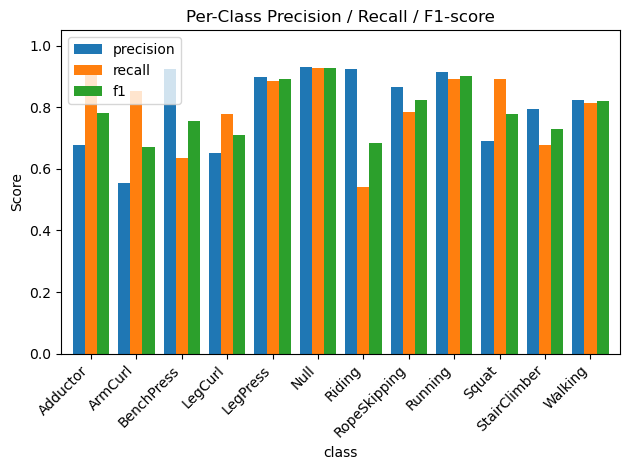

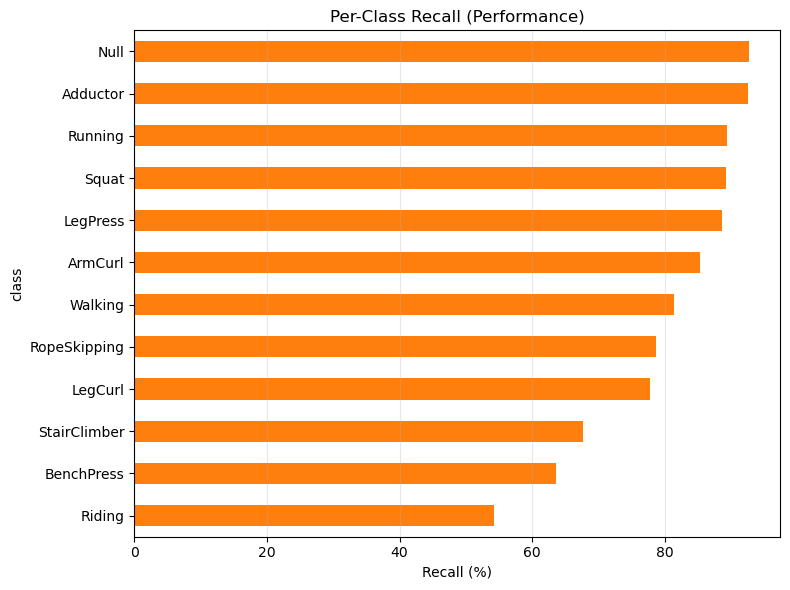

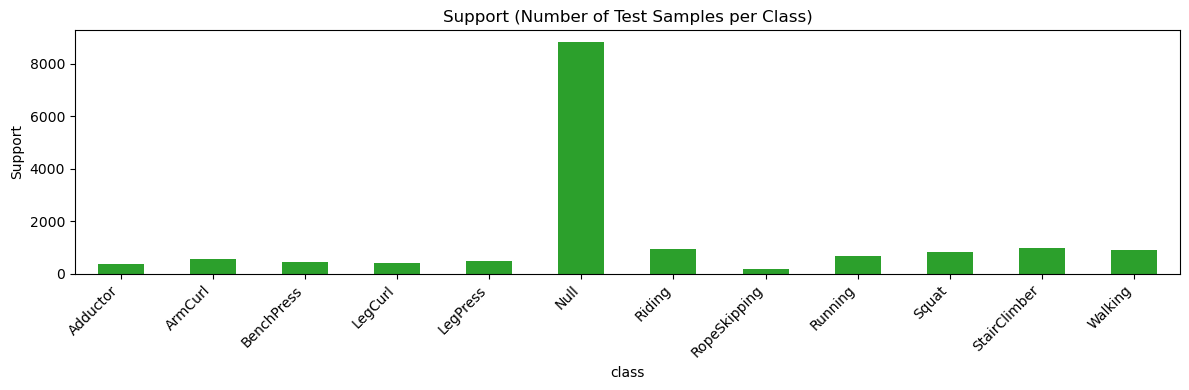

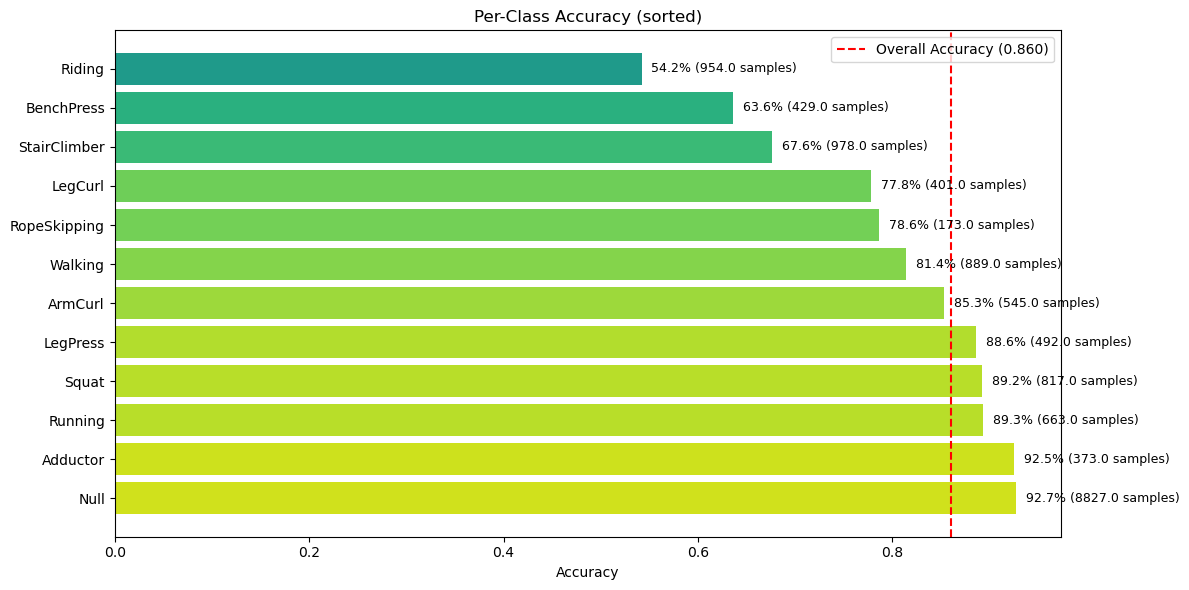

In [12]:
# ============================================================
# Visualization for the updated classification report
# ============================================================



# --- Paste data into a table ---
data = {
    'class': ['Adductor','ArmCurl','BenchPress','LegCurl','LegPress','Null',
              'Riding','RopeSkipping','Running','Squat','StairClimber','Walking'],
    
    'precision':[0.678,0.554,0.925,0.651,0.897,0.930,0.925,0.866,0.914,0.691,0.794,0.823],
    'recall'   :[0.925,0.853,0.636,0.778,0.886,0.927,0.542,0.786,0.893,0.892,0.676,0.814],
    'f1'       :[0.782,0.671,0.754,0.709,0.892,0.928,0.683,0.824,0.903,0.779,0.730,0.819],
    'support'  :[373,545,429,401,492,8827,954,173,663,817,978,889]
}

df = pd.DataFrame(data).set_index('class')

# ------------------------------------------------------------
# 1) Grouped bar chart (precision / recall / f1)
# ------------------------------------------------------------
plt.figure(figsize=(14,6))
df[['precision','recall','f1']].plot(kind='bar', width=0.8)
plt.title("Per-Class Precision / Recall / F1-score")
plt.ylabel("Score")
plt.ylim(0,1.05)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2) Per-class recall (performance)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
(df['recall']*100).sort_values().plot(kind='barh', color='C1')
plt.xlabel("Recall (%)")
plt.title("Per-Class Recall (Performance)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Support (test samples per class)
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
df['support'].plot(kind='bar', color='C2')
plt.title("Support (Number of Test Samples per Class)")
plt.ylabel("Support")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4) Per-class accuracy (recall = per-class accuracy)
# ------------------------------------------------------------
acc_df = df.copy()
acc_df['accuracy'] = acc_df['recall']
acc_sorted = acc_df.sort_values('accuracy', ascending=False)

overall_accuracy = 0.860  # from your report

plt.figure(figsize=(12,6))
colors = plt.cm.viridis(acc_sorted['accuracy'])
plt.barh(acc_sorted.index, acc_sorted['accuracy'], color=colors)
plt.axvline(overall_accuracy, color='red', linestyle='--',
            label=f'Overall Accuracy ({overall_accuracy:.3f})')
plt.legend()
plt.xlabel("Accuracy")
plt.title("Per-Class Accuracy (sorted)")

# annotate bars
for i, (cls, row) in enumerate(acc_sorted.iterrows()):
    plt.text(row['accuracy']+0.01, i,
             f"{row['accuracy']:.1%} ({row['support']} samples)",
             va='center', fontsize=9)

plt.tight_layout()
plt.show()




GENERATING MODEL 2 ARCHITECTURE DIAGRAM


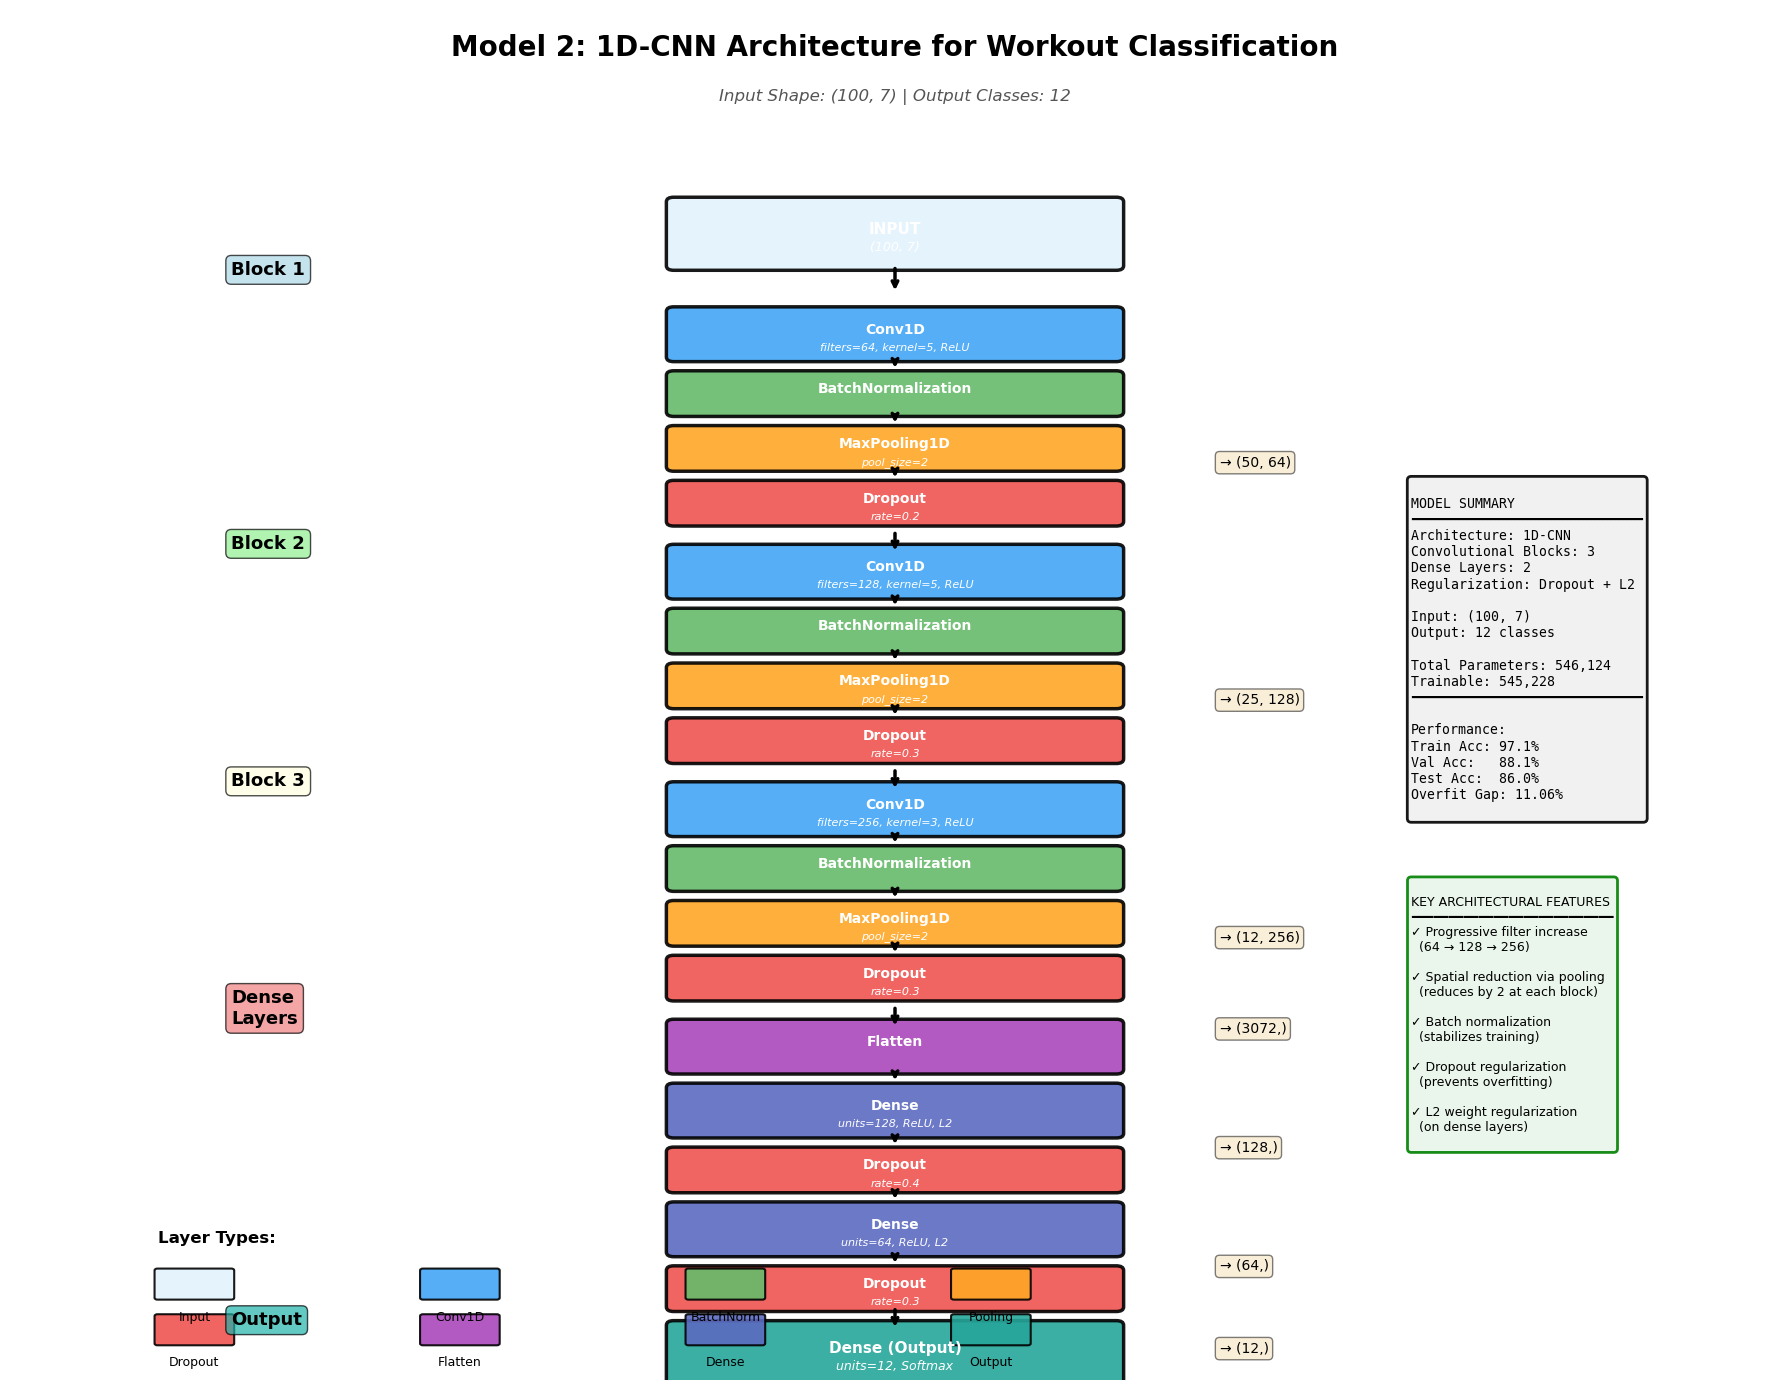

✓ Architecture diagram saved as 'model2_1dcnn_architecture.png'


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle
import numpy as np

print("\n" + "="*60)
print("GENERATING MODEL 2 ARCHITECTURE DIAGRAM")
print("="*60)

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_xlim(0, 12)
ax.set_ylim(0, 15)
ax.axis('off')

# Title
ax.text(6, 14.5, 'Model 2: 1D-CNN Architecture for Workout Classification', 
        ha='center', fontsize=20, fontweight='bold')
ax.text(6, 14, f'Input Shape: ({n_timesteps}, {n_channels}) | Output Classes: {num_classes}', 
        ha='center', fontsize=12, style='italic', color='#555')

# Color scheme
colors = {
    'input': '#e3f2fd',
    'conv': '#42a5f5',
    'bn': '#66bb6a',
    'pool': '#ffa726',
    'dropout': '#ef5350',
    'flatten': '#ab47bc',
    'dense': '#5c6bc0',
    'output': '#26a69a'
}

# Starting position
start_y = 13
y = start_y

# Helper function to draw a layer box
def draw_layer(ax, x, y, width, height, label, color, details='', fontsize=10):
    box = FancyBboxPatch((x, y), width, height,
                         boxstyle="round,pad=0.05",
                         edgecolor='black',
                         facecolor=color,
                         linewidth=2.5,
                         alpha=0.9)
    ax.add_patch(box)
    
    # Main label
    ax.text(x + width/2, y + height/2 + 0.05, label,
           ha='center', va='center',
           fontsize=fontsize, fontweight='bold', color='white')
    
    # Details
    if details:
        ax.text(x + width/2, y + height/2 - 0.15, details,
               ha='center', va='center',
               fontsize=fontsize-2, color='white', style='italic')

# Helper function to draw arrow
def draw_arrow(ax, x1, y1, x2, y2):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))

# ============================================
# INPUT LAYER
# ============================================
draw_layer(ax, 4.5, y-0.8, 3, 0.7, 'INPUT', colors['input'], 
           f'({n_timesteps}, {n_channels})', fontsize=11)
y -= 1.2
draw_arrow(ax, 6, y+0.4, 6, y+0.1)

# ============================================
# CONVOLUTIONAL BLOCK 1
# ============================================
# Block label
ax.text(1.5, y+0.3, 'Block 1', fontsize=13, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Conv1D', colors['conv'], 
           'filters=64, kernel=5, ReLU')
y -= 0.7
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'BatchNormalization', colors['bn'], '')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'MaxPooling1D', colors['pool'], 'pool_size=2')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'Dropout', colors['dropout'], 'rate=0.2')
y -= 0.7

# Output shape annotation
ax.text(8.2, y+0.8, f'→ ({n_timesteps//2}, 64)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.15)

# ============================================
# CONVOLUTIONAL BLOCK 2
# ============================================
ax.text(1.5, y-0.1, 'Block 2', fontsize=13, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Conv1D', colors['conv'], 
           'filters=128, kernel=5, ReLU')
y -= 0.7
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'BatchNormalization', colors['bn'], '')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'MaxPooling1D', colors['pool'], 'pool_size=2')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'Dropout', colors['dropout'], 'rate=0.3')
y -= 0.7

# Output shape annotation
ax.text(8.2, y+0.8, f'→ ({n_timesteps//4}, 128)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.15)

# ============================================
# CONVOLUTIONAL BLOCK 3
# ============================================
ax.text(1.5, y-0.1, 'Block 3', fontsize=13, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Conv1D', colors['conv'], 
           'filters=256, kernel=3, ReLU')
y -= 0.7
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'BatchNormalization', colors['bn'], '')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'MaxPooling1D', colors['pool'], 'pool_size=2')
y -= 0.6
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'Dropout', colors['dropout'], 'rate=0.3')
y -= 0.7

# Output shape annotation
ax.text(8.2, y+0.8, f'→ ({n_timesteps//8}, 256)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.15)

# ============================================
# DENSE LAYERS
# ============================================
ax.text(1.5, y-0.1, 'Dense\nLayers', fontsize=13, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Flatten', colors['flatten'], '')
y -= 0.7

# Output shape annotation
flattened_size = (n_timesteps//8) * 256
ax.text(8.2, y+0.5, f'→ ({flattened_size},)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Dense', colors['dense'], 
           'units=128, ReLU, L2')
y -= 0.7
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'Dropout', colors['dropout'], 'rate=0.4')
y -= 0.6

# Output shape annotation
ax.text(8.2, y+0.5, '→ (128,)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.6, 3, 0.5, 'Dense', colors['dense'], 
           'units=64, ReLU, L2')
y -= 0.7
draw_arrow(ax, 6, y+0.1, 6, y-0.05)

draw_layer(ax, 4.5, y-0.5, 3, 0.4, 'Dropout', colors['dropout'], 'rate=0.3')
y -= 0.6

# Output shape annotation
ax.text(8.2, y+0.5, '→ (64,)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

draw_arrow(ax, 6, y+0.1, 6, y-0.15)

# ============================================
# OUTPUT LAYER
# ============================================
ax.text(1.5, y-0.1, 'Output', fontsize=13, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightseagreen', alpha=0.7))

draw_layer(ax, 4.5, y-0.7, 3, 0.6, 'Dense (Output)', colors['output'], 
           f'units={num_classes}, Softmax', fontsize=11)

# Final output shape
ax.text(8.2, y-0.4, f'→ ({num_classes},)', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================
# LEGEND
# ============================================
legend_y = 1.2
ax.text(1, legend_y+0.3, 'Layer Types:', fontsize=12, fontweight='bold')

legend_items = [
    ('Input', colors['input']),
    ('Conv1D', colors['conv']),
    ('BatchNorm', colors['bn']),
    ('Pooling', colors['pool']),
    ('Dropout', colors['dropout']),
    ('Flatten', colors['flatten']),
    ('Dense', colors['dense']),
    ('Output', colors['output']),
]

for i, (name, color) in enumerate(legend_items):
    x_pos = 1 + (i % 4) * 1.8
    y_pos = legend_y - 0.3 if i < 4 else legend_y - 0.8
    
    box = FancyBboxPatch((x_pos, y_pos), 0.5, 0.3,
                        boxstyle="round,pad=0.02",
                        edgecolor='black',
                        facecolor=color,
                        linewidth=1.5,
                        alpha=0.9)
    ax.add_patch(box)
    ax.text(x_pos + 0.25, y_pos - 0.25, name,
           ha='center', fontsize=9)

# ============================================
# MODEL SUMMARY BOX
# ============================================
summary_text = f"""
MODEL SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Architecture: 1D-CNN
Convolutional Blocks: 3
Dense Layers: 2
Regularization: Dropout + L2

Input: ({n_timesteps}, {n_channels})
Output: {num_classes} classes

Total Parameters: {model_cnn.count_params():,}
Trainable: {sum([tf.keras.backend.count_params(w) for w in model_cnn.trainable_weights]):,}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Performance:
Train Acc: {train_acc_cnn:.1%}
Val Acc:   {val_acc_cnn:.1%}
Test Acc:  {test_acc_cnn:.1%}
Overfit Gap: {(train_acc_cnn - test_acc_cnn)*100:.2f}%
"""

ax.text(9.5, 8, summary_text, 
        fontsize=9.5,
        family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='#f0f0f0', 
                 edgecolor='black', linewidth=2, alpha=0.9))

# ============================================
# KEY FEATURES BOX
# ============================================
features_text = """
KEY ARCHITECTURAL FEATURES
━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Progressive filter increase
  (64 → 128 → 256)
  
✓ Spatial reduction via pooling
  (reduces by 2 at each block)
  
✓ Batch normalization
  (stabilizes training)
  
✓ Dropout regularization
  (prevents overfitting)
  
✓ L2 weight regularization
  (on dense layers)
"""

ax.text(9.5, 4, features_text, 
        fontsize=9,
        family='sans-serif',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='#e8f5e9', 
                 edgecolor='green', linewidth=2, alpha=0.9))

plt.tight_layout()
plt.savefig('model2_1dcnn_architecture.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✓ Architecture diagram saved as 'model2_1dcnn_architecture.png'")